In [98]:
import logging

import mrcfile
import numpy as np

from aspire.basis import FFBBasis2D, FSPCABasis
from aspire.classification import RIRClass2D
from aspire.image import Image
from aspire.operators import ScalarFilter

# from aspire.source import ArrayImageSource # Helpful hint if you want to BYO array.
from aspire.source import Simulation
from aspire.volume import Volume

logger = logging.getLogger(__name__)


In [99]:
##################################################
# Parameters
RESOLUTION = 64  # 300 used in paper (but needs a higher res source)
NUMBER_OF_TEST_IMAGES = 12000  # 24000 images in paper, 4096 is sufficient for clean dev.
DTYPE = np.float64
noise = 0.001 # zero for clean, 0.001 for dirty, 0.1 static

2021-05-12 13:08:33,335 INFO Appending a NoiseAdder to generation pipeline
2021-05-12 13:08:33,486 INFO Applying forward transformations in pipeline
2021-05-12 13:08:33,487 INFO All forward transformations applied
2021-05-12 13:08:33,487 INFO Loaded 10 images


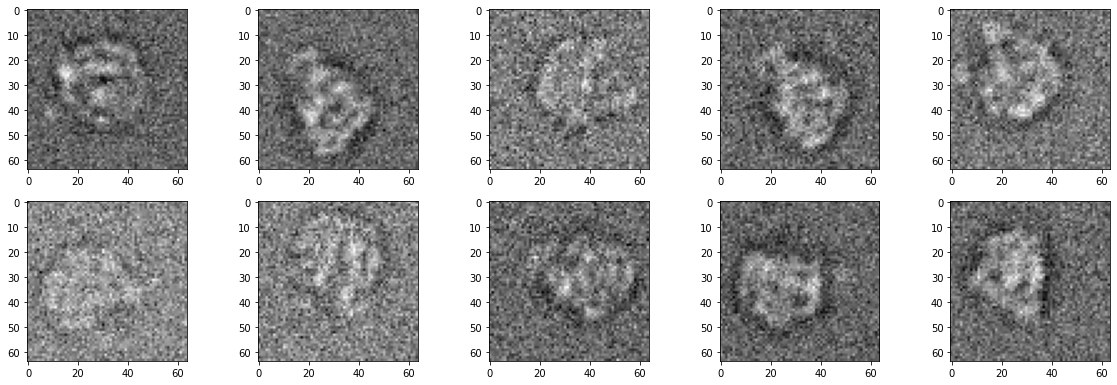

In [100]:
# Generate some projections downsampled to RESOLUTION
fh = mrcfile.open("../data/clean70SRibosome_vol_65p.mrc")  # ASPIRE_ROOT/tutorials/data/
v = Volume(fh.data.astype(DTYPE))
v = v.downsample((RESOLUTION,) * 3)

noise_var = noise * np.var(np.sum(v[0],axis=0))
noise_filter = ScalarFilter(dim=2, value=noise_var)

src = Simulation(
    L=v.resolution,
    n=NUMBER_OF_TEST_IMAGES,
    vols=v,
    dtype=DTYPE,
    noise_filter=noise_filter,
)
src.images(0, 10).show()

In [101]:
logger.info("Setting up FFB")
# Setup a Basis
basis = FFBBasis2D((RESOLUTION, RESOLUTION), dtype=DTYPE)
coefs = basis.evaluate_t(src.images(0, NUMBER_OF_TEST_IMAGES))

2021-05-12 13:08:34,371 INFO Setting up FFB
2021-05-12 13:08:34,372 INFO Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2021-05-12 13:09:33,027 INFO Applying forward transformations in pipeline
2021-05-12 13:09:33,027 INFO All forward transformations applied
2021-05-12 13:09:33,028 INFO Loaded 12000 images


In [102]:
logger.info("Setting up FSPCA")
fspca_basis = FSPCABasis(src, basis)
fspca_basis.build(coefs)
logger.info("FSPCA Complete")

2021-05-12 13:09:45,517 INFO Setting up FSPCA


100%|██████████| 92/92 [00:01<00:00, 52.89it/s]

2021-05-12 13:09:47,599 INFO FSPCA Complete


Here we configure RIRClass2D at the core of this notebook.

It tries to expose most of the arguments and hardcoded parameters from the legacy code as arguments with defaults from the legacy code.

It also should expose core stages of the algorithm as somewhat modular selectable components.
Example, you may set `nn_implementation="legacy"` to use the legacy batched dot product nearest neighbor search code instead of scikit-learn. Same for 'PCA'.

I am still working on using the new bispectrum code (I need the importance sampling part, bispect is probably okay); for now this uses the legacy CSR with importantance sampling.

In [103]:
rir = RIRClass2D(
    src,
    fspca_basis,
    fspca_components=400,
    alpha=1 / 3,
    bispectrum_componenents=300, # Compressed Features after last PCA stage.
    n_nbor=100,
    n_classes=10,
    sample_n=4000,  # MATLAB had a note suggesting 50k... which might actually turn off the feature; interesting.
    large_pca_implementation="sklearn",
    nn_implementation="sklearn", # I have sk version output hist of "distance" distribution for consideration.
    bispectrum_implementation="legacy",
)  # replaced PCA and NN codes with third party (slightly faster and more robust)


2021-05-12 13:10:45,965 INFO Applying forward transformations in pipeline
2021-05-12 13:10:45,965 INFO All forward transformations applied
2021-05-12 13:10:45,966 INFO Loaded 12000 images
2021-05-12 13:11:34,018 INFO Calculate Nearest Neighbors
2021-05-12 13:11:42,134 INFO Count reflected: 644450 (53.704166666666666%)


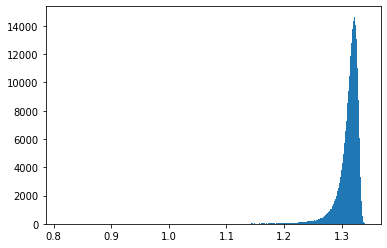

2021-05-12 13:11:44,543 INFO Begin Rotational Alignment of 12000 Classes
2021-05-12 13:20:55,183 INFO Classification Complete


In [104]:
# Running the classification takes some time, mainly in the alignment stage.
result = rir.classify()

logger.info('Classification Complete')


2021-05-12 13:21:53,301 INFO Applying forward transformations in pipeline
2021-05-12 13:21:53,301 INFO All forward transformations applied
2021-05-12 13:21:53,302 INFO Loaded 12000 images
2021-05-12 13:21:53,304 INFO Classed Sample:
2021-05-12 13:21:53,304 INFO Ignoring Reflected matches
2021-05-12 13:21:53,327 INFO Class 0 after rot/refl


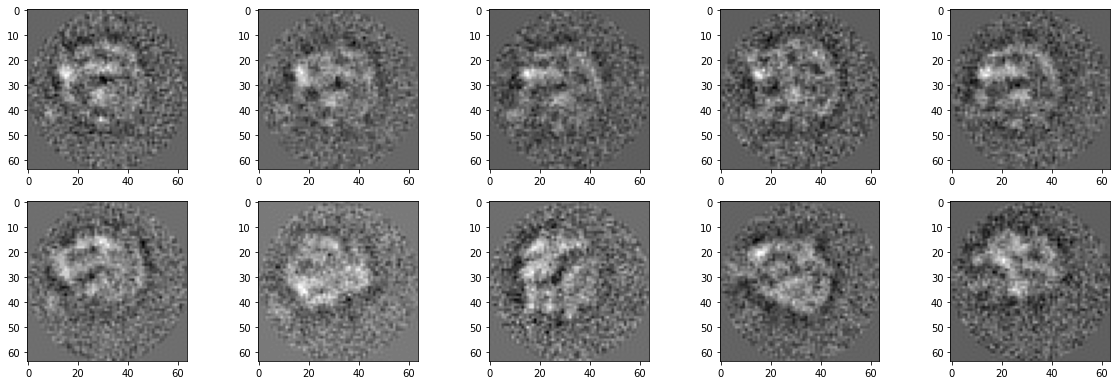

2021-05-12 13:21:54,203 INFO Ignoring Reflected matches
2021-05-12 13:21:54,239 INFO Class 1 after rot/refl


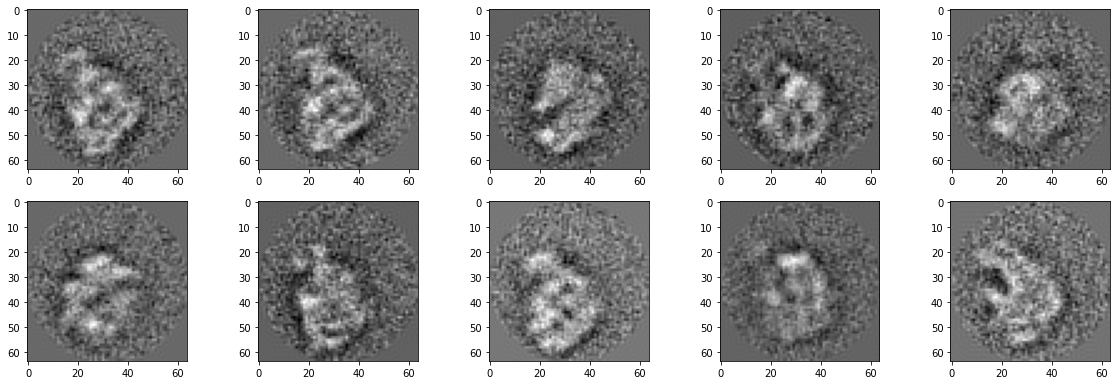

2021-05-12 13:21:55,116 INFO Ignoring Reflected matches
2021-05-12 13:21:55,151 INFO Class 2 after rot/refl


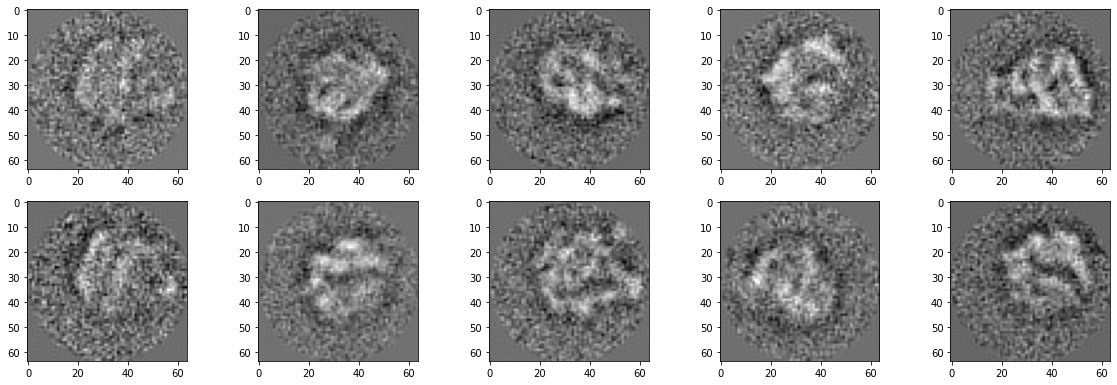

2021-05-12 13:21:56,147 INFO Ignoring Reflected matches
2021-05-12 13:21:56,198 INFO Class 3 after rot/refl


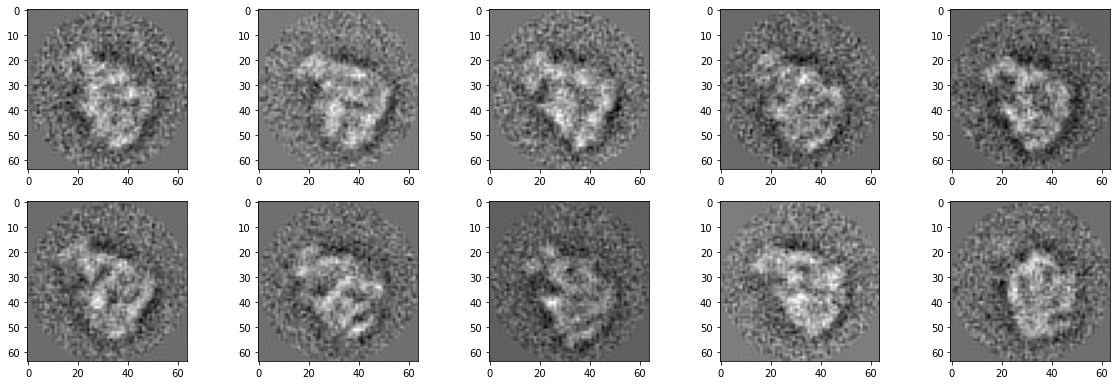

2021-05-12 13:21:57,072 INFO Ignoring Reflected matches
2021-05-12 13:21:57,103 INFO Class 4 after rot/refl


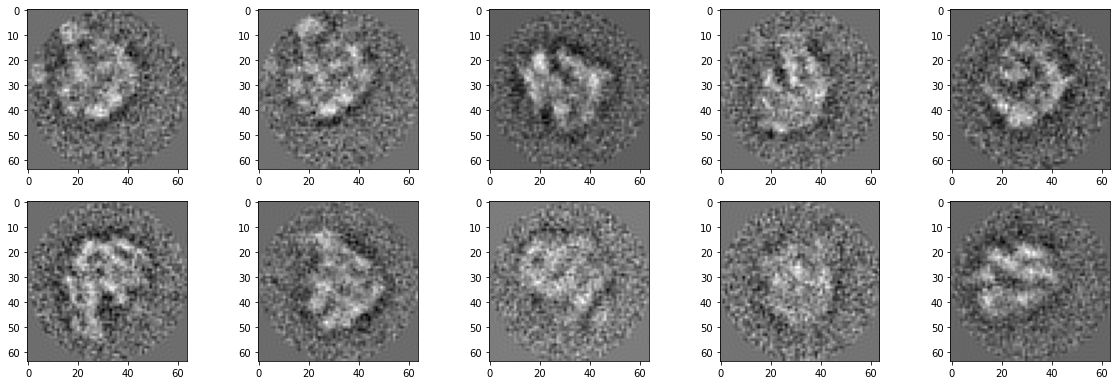

In [105]:
# We can review the resulting classes if we like. (Otherwise safe to skip this cell)
# It has been helpful to review the results manually.
# We are approaching the point where we need to something more clever (corrs/distributions).

# Unpack for review/debugging
classes, class_refl, rot, corr = result

def plot_helper(img, refl, columns=5, figsize=(20, 10)):
    import matplotlib.pyplot as plt

    plt.figure(figsize=figsize)
    for i, im in enumerate(img):
        plt.subplot(img.n_images // columns + 1, columns, i + 1)
        if refl[i]:
            plt.title("Reflected")
        plt.imshow(im, cmap="gray")
    plt.show()

# Lets peek at first couple image classes:
#   specifically for each class, thefirst ten nearest neighbors
Orig = src.images(0, NUMBER_OF_TEST_IMAGES)

include_refl = False  # I'll have to get some help regarding the reflected set. I don't like the results.

logger.info("Classed Sample:")
for c in range(5):
    # If we select just the non reflected neighbors things seem reasonable.
    if include_refl:
        neighbors = classes[c][:10]
    else:
        logger.info("Ignoring Reflected matches")
        selection = class_refl[c] == False
        neighbors = classes[c][selection][:10]  # not refl

    neighbors_img = Image(Orig[neighbors])

    # logger.info("before rot & refl")
    # neighbors_img.show()

    co = basis.evaluate_t(neighbors_img)
    logger.info(f"Class {c} after rot/refl")
    if include_refl:
        rco = basis.rotate(co, rot[c][:10], class_refl[c][:10])
    else:
        rco = basis.rotate(co, rot[c][selection][:10])  # not refl

    rotated_neighbors_img = basis.evaluate(rco)
    if include_refl:
        plot_helper(rotated_neighbors_img, class_refl[c][:10])
    else:
        rotated_neighbors_img.show()


2021-05-12 13:21:57,979 INFO Averaging
2021-05-12 13:21:57,980 INFO Output include_refl=False. Averaging only unreflected images.
2021-05-12 13:21:58,001 INFO Select 10 Classes from Nearest Neighbors
2021-05-12 13:22:56,212 INFO Applying forward transformations in pipeline
2021-05-12 13:22:56,213 INFO All forward transformations applied
2021-05-12 13:22:56,213 INFO Loaded 12000 images


100%|██████████| 10/10 [00:00<00:00, 34.17it/s]


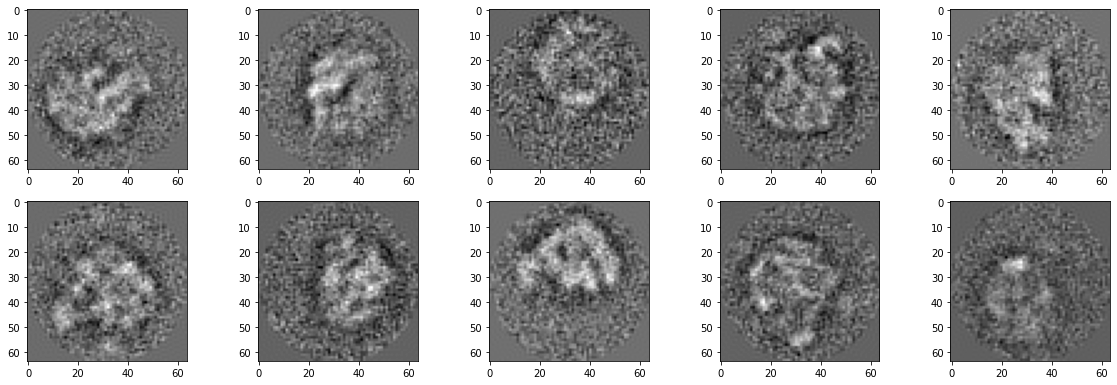

In [106]:
# Averaging

# Right now averaging is done in the `output` method.
# Mainly this is for review/development purposes. Intenionally unoptimized.
# Currently it recreates the image stack, but that's easily cached by the class (optimize later).
# Really we should truncate the set of things we want to align before alignment,
#   but the old codes didn't seem to do that. We do it here using a random sample for now (optimize later).

logger.info("Averaging")
avgs = rir.output(*result[:3], include_refl=False)

# Avgs is an Image so we can peek at it.
avgs.show()


So currently I need to work through a few more things before I consider cleanup for review. Top of list:

* Reflections, they're not working when included in the larger algorithm. I need to go back and verify how they worked in the legacy code. I do have a unit test that I thought was confirming the rotations and reflections of `Steerable` basis (pretty sure it does...).  Maybe it is relating to this `coef_b_r`. I can probably just reflect images in a dumb (run beginning twice) way as well to move things along if needed. Right now I'm still in questioning mode about this `coef_b_r`. There was also a bit of legacy code that rotated reflected images by 180*, but my results were better without that... Both seem like something that needs understanding. This area of the code had a few comments alluding to bugs...
* New bispec code needs importance sampling. Using truncated slabs of bispectrum is still too slow when including enough of slab that accuracy is comparable. Clearly needs importance feature or smarter truncation.  I don't understand that area of the legacy code yet, but we seem to have the supporting data structures since I am able to use them in the legacy implementation with ony a transpose.
* Would like to derive unit test for this that is more than a smoke test, but not a full on demo (like this).
* Amit is really interested in Approx Nearest Neighbor suddenly (even though its just not the slow part at this stage of development IMO, and we didn't care that this algo wasn't running for who knows how long...). I might pick an ANN and try to stuff it in here just to keep things positive. I already built the supporting code in the class to swap things (I'm actually pleased with the factoring of the stages, you might like it too, see  `RIRClass2D.classify`).
* Should not align whole set. This area is slow and we throw almost all of it out if asking for n_classes<<n_img.
* PCA vs ComplexPCA.  Complex results doesn't seem equivalent to two real results superficially, will look into it more.  Currently uses complex extension for the sklearn PCA component.
* all the other things
